In [177]:
!pip install "dask[complete]"

In [178]:
!pip install nltk

In [179]:
!pip install wordcloud

In [180]:
!pip install gensim

In [181]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [182]:
!pip install 'transformers[torch]'

In [183]:
from dask.distributed import Client, LocalCluster, progress,  as_completed
from dask import bag as db
import dask
from tqdm import tqdm
import os
from dask.diagnostics import ProgressBar
from time import time

In [184]:
!rm -r ./output_mañaneras

In [185]:
!curl ipecho.net/plain
!sudo lsof -i -P -n | grep LISTEN

152.70.138.140sudo: lsof: command not found


In [186]:
from bs4 import BeautifulSoup
import requests
import re
import random
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [187]:
def download_AMLOVE_conferences(start_page, end_page, client_id):
  base_link = lambda page_number: f"https://lopezobrador.org.mx/transcripciones/page/{page_number}/"
  matutina_counter = 0

  print(f"Client {client_id} started processing pages {start_page} to {end_page}")

  for page_n_it in range(start_page, end_page + 1):
    req   = requests.get(base_link(page_n_it))
    soup  = BeautifulSoup(req.content, 'html.parser')
    href_links = [a['href'] for a in soup.select("h2.entry-title a")]
    # for href in href_links:
    #     print(href)
    for matutina_link in href_links:
      delay_seconds = random.uniform(1, 3)
      time.sleep(delay_seconds)

      req           = requests.get(matutina_link)
      soup          = BeautifulSoup(req.content, 'html.parser')
      date_matutina = soup.select("span.entry-date a")[0].get_text().replace(' ', '_').replace(',', '')
      date_matutina = f"{matutina_counter}_" + date_matutina
      content       = soup.find_all("div", class_="entry-content")
      text_content = ""
      for element in content:
        text_content += element.get_text()
      matutina_counter += 1
      with open(f"./output_mañaneras/{date_matutina}.txt", "w", encoding="utf-8") as file:
          file.write(text_content)

    # print(f"dict_num: {page_n_it}\t mañaneras: {matutina_counter}")
    print(f"Client {client_id}, Page {page_n_it} processed, {matutina_counter} files downloaded")

In [188]:
cluster = LocalCluster(n_workers=8)

/opt/conda/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38285 instead
  warnings.warn(
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the chil

In [189]:
client1 = Client(cluster)
client2 = Client(cluster)

In [190]:
dask.config.set({"distributed.dashboard.link": "/proxy/{port}/status"})

In [191]:
client1

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38285/status,
Dashboard: /proxy/38285/status,Workers: 8
Total threads: 8,Total memory: 27.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35159,Workers: 8
Dashboard: /proxy/38285/status,Total threads: 8
Started: Just now,Total memory: 27.95 GiB
Comm: tcp://127.0.0.1:41193,Total threads: 1
Dashboard: /proxy/40363/status,Memory: 3.49 GiB
Nanny: tcp://127.0.0.1:39241,


In [192]:
client2

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38285/status,
Dashboard: /proxy/38285/status,Workers: 8
Total threads: 8,Total memory: 27.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35159,Workers: 8
Dashboard: /proxy/38285/status,Total threads: 8
Started: Just now,Total memory: 27.95 GiB
Comm: tcp://127.0.0.1:41193,Total threads: 1
Dashboard: /proxy/40363/status,Memory: 3.49 GiB
Nanny: tcp://127.0.0.1:39241,


## Download the files in each client

In [193]:
!ls

corpus_work  DaskDistributed.ipynb  lost+found	nltk_data


In [194]:
os.mkdir("./output_mañaneras/")

In [195]:
generate_args = lambda total_pages, step: [(start, end, task_id) for task_id, (start, end) in enumerate(zip(range(1, total_pages + 1, step), range(step, total_pages + 1, step)), start=1)]

In [196]:
args = generate_args(80, 8)
delayed_results = [dask.delayed(download_AMLOVE_conferences)(arg1, arg2, arg3) for arg1, arg2, arg3 in args]
# futures = cluster.map(download_AMLOVE_conferences, *zip(*args))

In [197]:
args

[(1, 8, 1),
 (9, 16, 2),
 (17, 24, 3),
 (25, 32, 4),
 (33, 40, 5),
 (41, 48, 6),
 (49, 56, 7),
 (57, 64, 8),
 (65, 72, 9),
 (73, 80, 10)]

In [198]:
ProgressBar().register()
features = dask.compute(*delayed_results)

## Read TXT files

In [199]:
import dask.bag as db
import nltk
from nltk.corpus import PlaintextCorpusReader
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/datascience/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [200]:
directory_path  = "output_mañaneras/"
corpus          = PlaintextCorpusReader(directory_path, '.*\.txt')

In [201]:
corpus.words()

['2022', ':', 'Año', 'de', 'Ricardo', 'Flores', ...]

In [202]:
len(corpus.words())

5366688

## Word Frequency

In [203]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from time import time
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/datascience/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datascience/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [204]:
def timer_func(func):
    # This function shows the execution time of
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

In [205]:
@timer_func
def scatter_plot_with_title(data_frame, x_column, y_column, title):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.scatter(data_frame[x_column], data_frame[y_column])
    plt.title(title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

In [206]:
@timer_func
def get_frequency_corpus(my_corpus):
  frequent_words = {}
  for word in my_corpus.words():
    if word in frequent_words:
      frequent_words[word]+=1
    else:
      frequent_words[word]=1
  keys = list(frequent_words.keys())
  values = list(frequent_words.values())
  sorted_value_index = np.flip(np.argsort(values))
  sorted_dict = [(keys[i], values[i]) for i in sorted_value_index]
  return sorted_dict

In [207]:
@timer_func
def remove_stopwords(frequency_list):
    stop_words = set(stopwords.words("spanish"))
    filtered_tokens = [(token, count) for token,count in frequency_list if token.lower() not in stop_words]
    return filtered_tokens

In [208]:
@timer_func
def clean_alphanumeric(frequency_list):
   return  [(token, count) for token,count in frequency_list if token.isalnum()]

In [209]:
@timer_func
def lowercase_tokens(frequency_list):
  return [(token.lower(), count) for token, count in frequency_list]

In [210]:
@timer_func
def clean_unnecessary_tokens(frequency_list, list_tokens):
  return [(token, count) for token,count in frequency_list if token not in list_tokens]

In [211]:
@timer_func
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [212]:
frequency = get_frequency_corpus(corpus)
frequency[:100]

Function 'get_frequency_corpus' executed in 5.8349s


[(',', 451268),
 ('de', 248667),
 ('.', 180527),
 ('que', 169806),
 ('la', 134557),
 ('el', 114030),
 ('a', 113432),
 ('en', 109577),
 ('y', 104971),
 ('se', 73026),
 ('los', 66881),
 ('no', 59510),
 ('es', 55354),
 (':', 44898),
 ('con', 42600),
 ('del', 42365),
 ('lo', 41683),
 ('un', 38875),
 ('por', 36304),
 ('para', 35823),
 ('las', 32296),
 ('una', 30035),
 ('ya', 24831),
 ('Y', 24263),
 ('¿', 23434),
 ('más', 22178),
 ('porque', 21926),
 ('al', 19634),
 ('?', 19212),
 ('como', 19145),
 ('pero', 17346),
 ('también', 16736),
 ('hay', 16369),
 ('está', 15964),
 ('eso', 15580),
 ('LÓPEZ', 15320),
 ('MANUEL', 15151),
 ('ANDRÉS', 15113),
 ('OBRADOR', 15088),
 ('PRESIDENTE', 15088),
 ('o', 14147),
 ('este', 13875),
 ('presidente', 13860),
 ('mil', 13601),
 (';', 13074),
 ('su', 12588),
 ('México', 12359),
 ('todo', 12225),
 ('muy', 12170),
 ('si', 12087),
 ('va', 11947),
 ('son', 11269),
 ('le', 11063),
 ('nos', 10922),
 ('vamos', 10370),
 ('Entonces', 10262),
 ('todos', 10201),
 ('‘',

<Axes: xlabel='position', ylabel='count'>

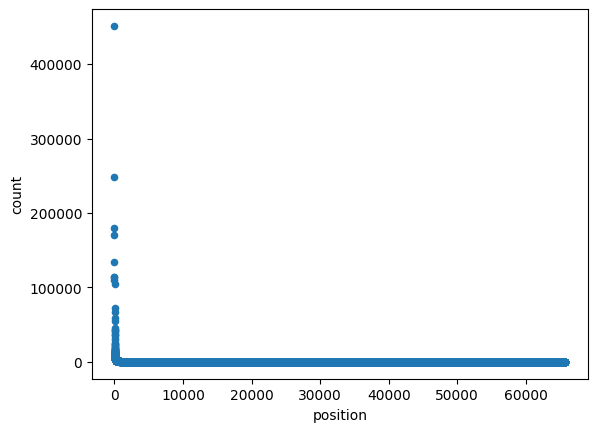

In [213]:
df              = pd.DataFrame(frequency, columns=["token", "count"])
df["position"] = df.apply((lambda x : x.name), axis=1)
df.plot.scatter(x="position", y="count")

<Axes: xlabel='position', ylabel='zipf'>

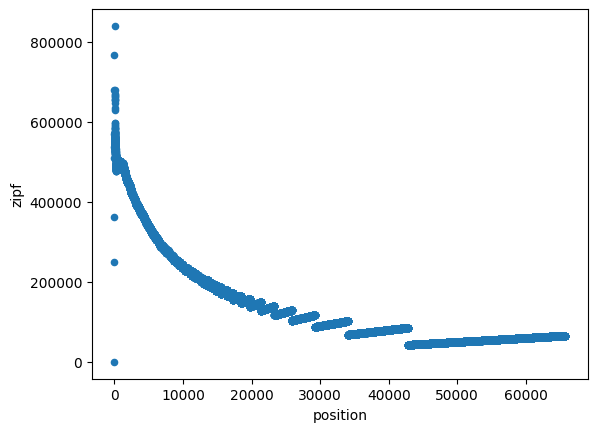

In [214]:
df["zipf"]= df.apply((lambda x: x.name*x["count"]), axis=1)
df.plot.scatter(x='position',y='zipf')

In [215]:
new_frequency = remove_stopwords(frequency)
new_frequency[:20]

Function 'remove_stopwords' executed in 0.0285s


[(',', 451268),
 ('.', 180527),
 (':', 44898),
 ('¿', 23434),
 ('?', 19212),
 ('LÓPEZ', 15320),
 ('MANUEL', 15151),
 ('ANDRÉS', 15113),
 ('OBRADOR', 15088),
 ('PRESIDENTE', 15088),
 ('presidente', 13860),
 ('mil', 13601),
 (';', 13074),
 ('México', 12359),
 ('si', 12087),
 ('va', 11947),
 ('vamos', 10370),
 ('Entonces', 10262),
 ('‘', 10073),
 ('aquí', 8251)]

In [216]:
new_frequency = clean_alphanumeric(new_frequency)
new_frequency[:20]

Function 'clean_alphanumeric' executed in 0.0197s


[('LÓPEZ', 15320),
 ('MANUEL', 15151),
 ('ANDRÉS', 15113),
 ('OBRADOR', 15088),
 ('PRESIDENTE', 15088),
 ('presidente', 13860),
 ('mil', 13601),
 ('México', 12359),
 ('si', 12087),
 ('va', 11947),
 ('vamos', 10370),
 ('Entonces', 10262),
 ('aquí', 8251),
 ('ver', 7708),
 ('pues', 7422),
 ('dos', 7242),
 ('gobierno', 7115),
 ('pueblo', 6874),
 ('millones', 6782),
 ('ahí', 6682)]

In [217]:
tokens_to_remove  = ["LÓPEZ", "MANUEL", "ANDRÉS", "OBRADOR", "PRESIDENTE", "PREGUNTA"]
new_frequency     = clean_unnecessary_tokens(new_frequency, tokens_to_remove)

Function 'clean_unnecessary_tokens' executed in 0.0168s


In [218]:
new_frequency     = lowercase_tokens(new_frequency)

Function 'lowercase_tokens' executed in 0.0217s


<Axes: xlabel='position', ylabel='count'>

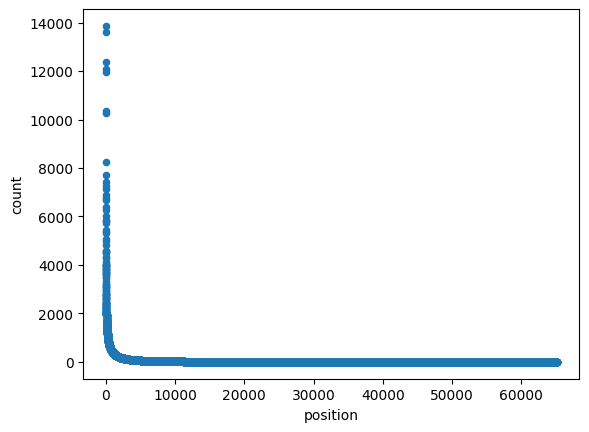

In [219]:
df = pd.DataFrame(new_frequency, columns =['token', 'count'])
df["position"]= df.apply((lambda x: x.name), axis=1)
df.plot.scatter(x='position',y='count')

<Axes: xlabel='position', ylabel='zipf'>

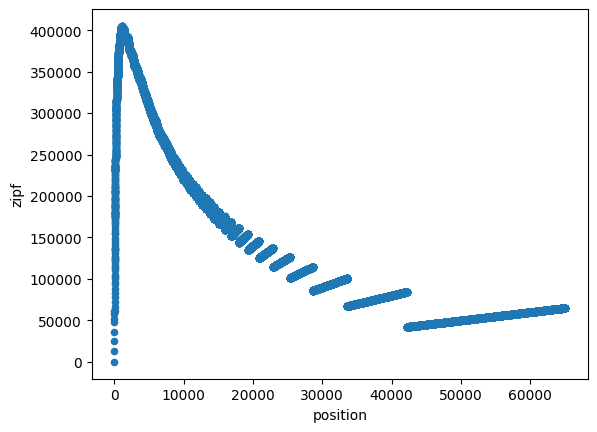

In [220]:
df["zipf"]= df.apply((lambda x: x.name*x["count"]), axis=1)
df.plot.scatter(x='position',y='zipf')

In [221]:
df.head(20)

,token,count,position,zipf
0,presidente,13860,0,0
1,mil,13601,1,13601
2,méxico,12359,2,24718
3,si,12087,3,36261
4,va,11947,4,47788
5,vamos,10370,5,51850
6,entonces,10262,6,61572
7,aquí,8251,7,57757
8,ver,7708,8,61664
9,pues,7422,9,66798


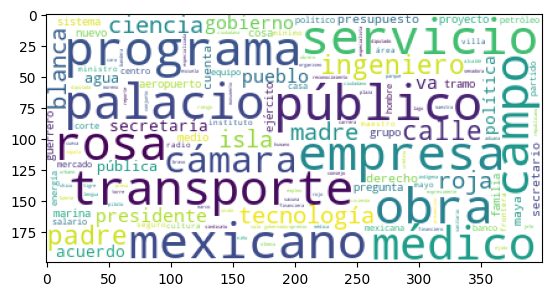

In [222]:
words_from_dataframe = ' '.join(df.values.flatten().astype(str))
oc_cloud= WordCloud(background_color='white', max_words=300,
                    max_font_size=40,random_state=1).generate(words_from_dataframe)
plt.imshow(oc_cloud)

In [223]:
analyzer = nltk.Text(corpus.words())
analyzer.concordance("México")

Displaying 25 of 12415 matches:
a mentir para atacar al Gobierno de México . el expresidente Felipe Calderón H
renaje sobre la playa no ocurrió en México , sino en una playa de España . Así
mente , para golpear al Gobierno de México y que les sirvió al expresidente Ca
adio , vean la televisión . Es otro México , no es el que se está viviendo aho
 que ellos se sentían los dueños de México , entonces les molesta mucho que ah
agonista principal sea el pueblo de México , porque no tienen convicciones dem
ndo . Y no es un asunto nada más de México , es del mundo . ¿ Ustedes creen qu
tre todos de que no haya tortura en México , es decir , en México no hay tortu
a tortura en México , es decir , en México no hay tortura , eso es algo histór
 muy fuerte el que el presidente de México señale a estos jueces aquí . Entonc
ver . Se le detiene en la Ciudad de México , que es el 18 de agosto . Lo liber
do el país . No hay un municipio de México , uno de México , que no tenga un p
hay un municipio de 

In [224]:
analyzer.concordance("López")

Displaying 25 of 16675 matches:
ón Mexicana PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Buenos días . Ánimo . Ya n
obierno del presidente Andrés Manuel López Obrador , aunque para ello tenga que
oritaria del gobierno del presidente López Obrador . El periodista Raymundo Riv
nado por el presidente Andrés Manuel López Obrador . La crítica no es tolerable
ir en contra de la administración de López Obrador . Todo lo manejan al respect
tración del presidente Andrés Manuel López Obrador , lo cual es falso . Esta de
u permiso . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Vamos a la fila 3 , fila 3
atenderme . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Muy bien . Pues vamos a qu
 de Jesús . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Tenemos información de que
 tardaría . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : De acuerdo . INTERLOCUTOR 
residente . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Quedamos en la fila 3 , ¿ 
 política . PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR : Pues mire , lo que sucede 
: ¿ Dond

In [225]:
analyzer.collocations()

ANDRÉS MANUEL; PRESIDENTE ANDRÉS; LÓPEZ OBRADOR; MANUEL LÓPEZ; Estados
Unidos; por ciento; señor presidente; Tren Maya; todos los; nada más;
Guardia Nacional; RAMÍREZ CUEVAS; JESÚS RAMÍREZ; García Luna; Buenos
días; Poder Judicial; Quintana Roo; Muchas gracias; Baja California;
sobre todo


## Embeddings

In [226]:
df

,token,count,position,zipf
0,presidente,13860,0,0
1,mil,13601,1,13601
2,méxico,12359,2,24718
3,si,12087,3,36261
4,va,11947,4,47788
...,...,...,...,...
65077,externando,1,65077,65077
65078,investigarlos,1,65078,65078
65079,externaremos,1,65079,65079
65080,manifestarlas,1,65080,65080


In [227]:
!pip install torchtext

In [228]:
import torch
import torchtext.vocab as vocab

In [229]:
glove = vocab.GloVe(name='6B', dim=100)

In [230]:
print('Loaded {} words'.format(len(glove.itos)))

Loaded 400000 words


In [231]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

In [232]:
get_word("idolo")

tensor([-0.2384, -0.4166,  0.2639,  0.7823, -0.4305, -0.0784,  0.5448,  0.2084,
         0.1916, -0.7260,  0.1376, -0.0535, -0.1257,  0.2975, -0.3390,  0.1882,
        -0.3035,  0.4057,  0.0938,  0.4012,  0.1799, -0.1351, -0.4766, -0.0226,
        -0.0407,  0.6021, -0.1469,  0.1161,  0.3504, -0.0220,  0.0079, -0.7572,
        -0.3142,  0.0492, -0.2299, -0.0455, -0.4619, -0.5788,  0.1020,  0.3163,
         0.5873,  0.1444,  0.0363,  0.0109, -0.2745, -0.7890, -0.1742,  0.7213,
        -0.3956,  0.1505,  0.1213,  0.1618, -0.6333, -0.3902,  0.3238,  0.4498,
        -0.1396,  0.3086, -0.4190, -0.2498, -0.3205, -0.7572, -0.3245, -0.8803,
         0.3841,  0.1420, -0.8674, -0.0712,  0.3599,  0.1558,  0.6275,  0.4883,
         0.1845,  0.3039, -0.2994,  0.3944,  0.2047,  0.5530,  0.5894,  0.0218,
        -0.2437, -0.2351,  0.0752, -0.0642,  0.3435,  0.1865, -0.3076,  0.1613,
         0.2608,  0.3506, -0.0951,  0.0971,  0.3906, -0.0252,  0.5598, -0.0302,
         0.1836,  0.0717, -0.3901,  0.01

In [233]:
df["token"].to_numpy()

array(['presidente', 'mil', 'méxico', ..., 'externaremos',
       'manifestarlas', 'llamaos'], dtype=object)

In [234]:
df = pd.DataFrame(new_frequency, columns =['token', 'count'])

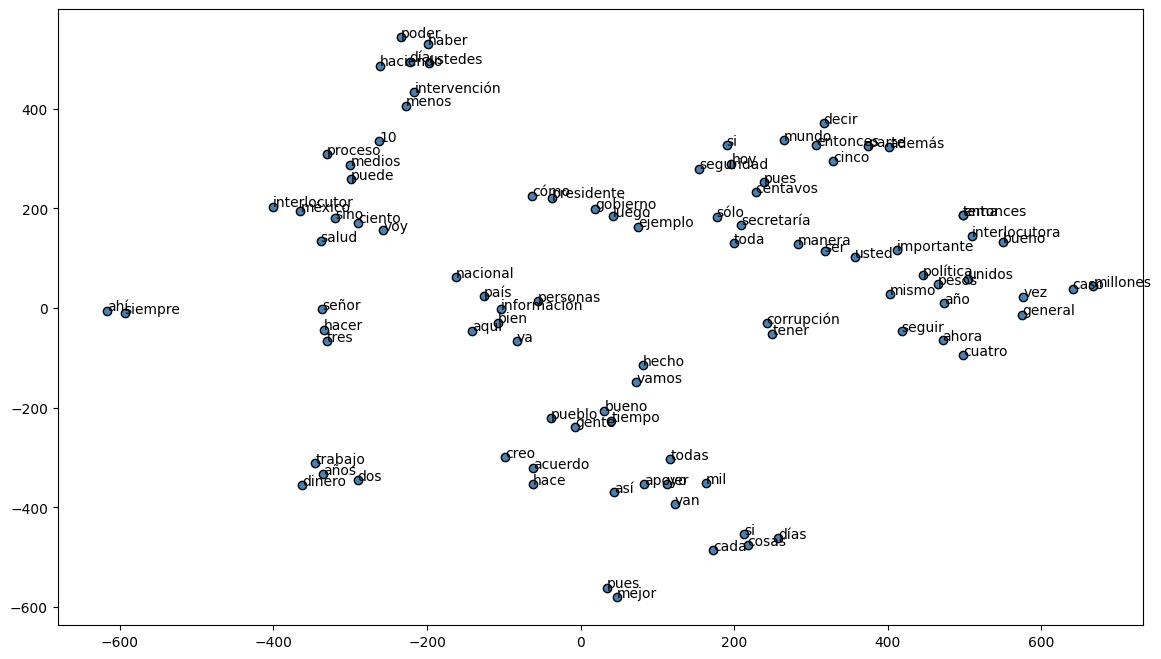

In [235]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words_to_plot = df["token"].to_numpy()

# Get the GloVe vectors for the words
# word_vectors = [glove.vectors[glove.stoi[word]] for word in words_to_plot]
word_vectors  = []
for word in words_to_plot[:100]:
  try:
    word_vectors.append(glove.vectors[glove.stoi[word]])
  except:
    continue


word_vectors = torch.stack(word_vectors)  # Convert to a PyTorch tensor
word_labels = words_to_plot

# Perform t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)

# Create the scatter plot
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(word_labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

plt.show()

## SkipGrams

In [236]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

CONTEXT_SIZE  = 2

In [237]:
nltk.download('stopwords')
stop_words  = set(stopwords.words('spanish'))
our_words   = corpus.words()
filtered_text = [word for word in our_words if word.lower() not in stop_words]
filtered_text = [word for word in filtered_text if not re.match(r'^\d+$', word)]
filtered_text = [re.sub(r'[^\w\s]', '', word) for word in filtered_text]
filtered_text = [word.lower() for word in filtered_text]
filtered_text = list(filter(None, filtered_text))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datascience/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [238]:
text          = filtered_text

split_ind = (int)(len(text) * 0.8)

vocab = set(text)
vocab_size = len(vocab)
print('vocab_size:', vocab_size)

w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}

vocab_size: 56245


In [239]:
import random
def create_skipgram_dataset(text):
  data = []
  for i in range(2, len(text) - 2):
    data.append((text[i], text[i-2], 1))
    data.append((text[i], text[i-1], 1))
    data.append((text[i], text[i+1], 1))
    data.append((text[i], text[i+2], 1))

    for _ in range(4):
      if random.random() < 0.5 or i >= len(text)-3:
        rand_id   = random.randint(0, i-1)
      else:
        rand_id   = random.randint(i+3, len(text)-1)
      data.append((text[i], text[rand_id], 0))
    return data

In [240]:
skipgram_train  = create_skipgram_dataset(text)
print("skipgram sample", skipgram_train[0])

skipgram sample ('flores', 'año', 1)


In [241]:
skipgram_train

[('flores', 'año', 1),
 ('flores', 'ricardo', 1),
 ('flores', 'magón', 1),
 ('flores', 'precursor', 1),
 ('flores', 'allá', 0),
 ('flores', 'ricardo', 0),
 ('flores', 'aprobación', 0),
 ('flores', 'ricardo', 0)]

In [242]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, embed_size):
    super(SkipGram, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embed_size)
  def forward(self, focus, context):
    embed_focus     = self.embeddings(focus).view((1, -1))
    embed_ctx       = self.embeddings(context).view((1, -1))
    score           = torch.mm(embed_focus, torch.t(embed_ctx))
    log_probs       = F.logsigmoid(score)
    return log_probs

In [243]:
def train_skipgram():
  embed_size        = 100
  learning_rate     = 0.001
  n_epoch           = 30

  losses            =  []
  loss_fn           = nn.MSELoss()
  model             = SkipGram(vocab_size, embed_size)
  print(model)
  optimizer         = optim.SGD(model.parameters(), lr=learning_rate)

  for epoch in range(n_epoch):
    total_loss      = .0
    for in_w, out_w, target in skipgram_train:
      in_w_var      = Variable(torch.LongTensor([w2i[in_w]]))
      out_w_var     = Variable(torch.LongTensor([w2i[out_w]]))

      model.zero_grad()
      log_probs     = model(in_w_var, out_w_var)
      loss = loss_fn(log_probs[0], Variable(torch.Tensor([target])))

      loss.backward()
      optimizer.step()

      total_loss    += loss.data.item()
    losses.append(total_loss)
  return model, losses

In [244]:
skipgram_model, skipgram_losses = train_skipgram()

SkipGram(
  (embeddings): Embedding(56245, 100)
)


In [245]:
def test_skipgram(test_data, model):
  correct_ct      = 0
  for in_w, out_w, target in test_data:
    in_w_var      = Variable(torch.LongTensor([w2i[in_w]]))
    out_w_var     = Variable(torch.LongTensor([w2i[out_w]]))
    # print(f"target: {target}")
    # print(f"in w var: {in_w_var}")
    # print(f"out w var: {out_w_var}")

    model.zero_grad()
    log_probs     = model(in_w_var, out_w_var)
    # print(f"log_probs: {log_probs}")
    _, predicted  = torch.max(log_probs.data, 1)
    # print(f"1. line: {_}")
    # print(f"1. predicted: {predicted}")
    predicted = predicted[0]
    # print(f"2. predicted: {predicted}")
    if predicted == target:
      correct_ct += 1
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [246]:
skipgram_model.embeddings(torch.tensor([30]))

tensor([[ 1.2605e+00, -3.8132e-01, -5.3615e-01, -2.1429e+00, -9.8881e-01,
          4.6520e-01, -1.3582e+00,  1.8795e-01, -1.1753e+00, -1.3879e+00,
          6.2592e-02,  8.4714e-01,  1.9469e-01,  1.0850e+00, -1.1697e-01,
         -1.2120e-01,  2.7449e+00, -8.5823e-01, -3.5186e-01,  9.9942e-01,
          1.1843e+00, -8.0943e-01,  1.4160e+00, -1.1739e+00, -2.0347e-03,
          9.6710e-02, -1.5938e-01, -1.3068e-01, -4.2915e-02,  1.4746e+00,
         -5.1863e-02,  2.2796e-01,  1.6376e-01, -7.5918e-01,  3.2130e-01,
          9.0360e-01, -7.4365e-01, -1.0270e-01,  7.2246e-01, -9.7884e-01,
         -4.8420e-01, -1.2566e-01, -1.2366e+00,  3.7705e-01,  9.1174e-01,
          6.9001e-01, -1.2801e-01,  1.4557e-01,  1.0935e-01,  2.0832e-01,
          1.9638e+00, -2.3556e-01, -7.4436e-01, -1.3292e+00,  2.9691e-01,
         -1.1268e+00,  3.9561e-01, -5.6628e-01, -2.1153e+00, -1.2545e+00,
          1.2007e-01, -1.1421e+00,  1.4306e+00,  4.1801e-01,  6.6904e-02,
          1.9809e-01,  1.4209e-01,  7.

In [247]:
test_skipgram(skipgram_train, skipgram_model)

Accuracy: 0.0% (0/8)
Accuracy: 0.0% (0/8)
Accuracy: 0.0% (0/8)
Accuracy: 0.0% (0/8)
Accuracy: 12.5% (1/8)
Accuracy: 25.0% (2/8)
Accuracy: 37.5% (3/8)
Accuracy: 50.0% (4/8)


In [248]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [249]:
# Extract word embeddings from the model
# tardó casi 12 minutos
word_embeddings = skipgram_model.embeddings.weight.data.numpy()

# Perform t-SNE on the word embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(word_embeddings)

In [250]:
print("one")

one


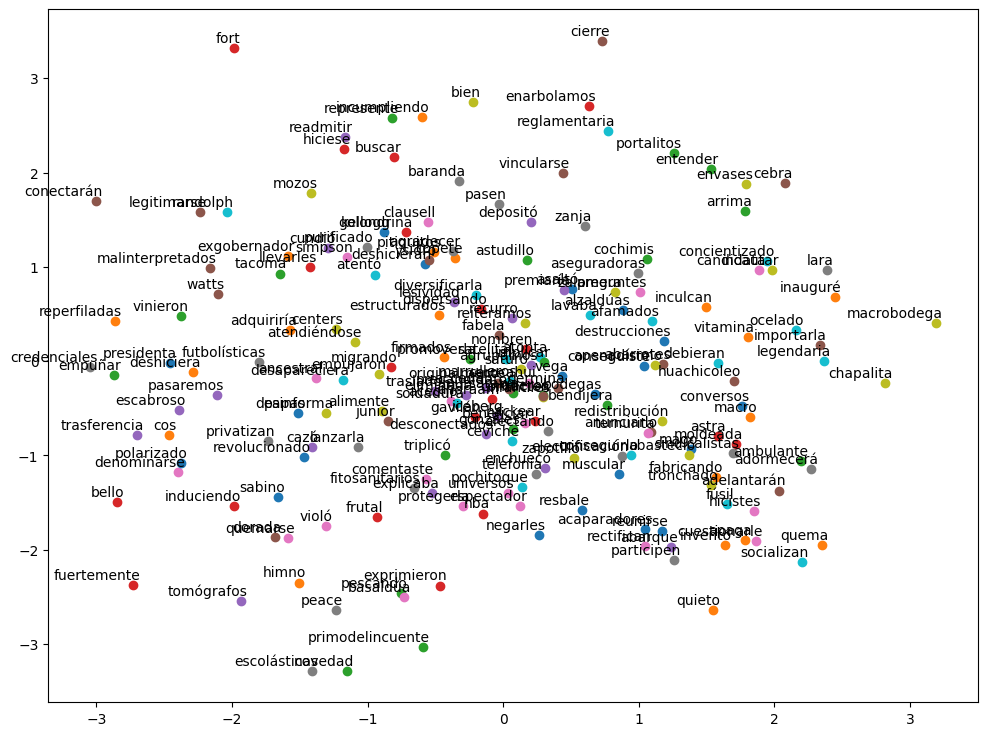

In [251]:

# Visualize the embeddings
plt.figure(figsize=(12, 9))
counter = 0
for i, label in i2w.items():
    if counter == 200:
      break
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    counter += 1

plt.show()

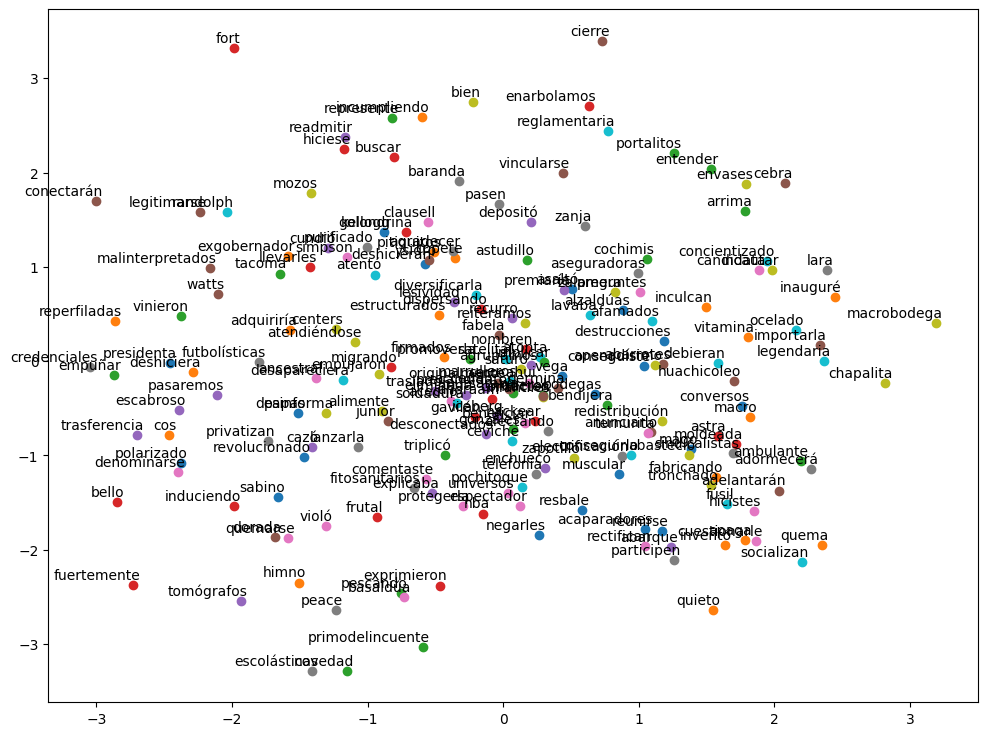

In [252]:
from sklearn.metrics.pairwise import cosine_distances

# Set a threshold for proximity (you can adjust this as needed)
threshold = 0.3

# Calculate cosine distances between word embeddings
distances = cosine_distances(word_embeddings)

# Visualize the embeddings
plt.figure(figsize=(12, 9))
counter = 0

for i, label in i2w.items():
    if counter == 200:
        break

    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    # Check the proximity of this word to others
    for j, label2 in i2w.items():
        if i != j and distances[i, j] < threshold:
            x2, y2 = embeddings_2d[j]
            plt.plot([x, x2], [y, y2], 'k-', alpha=0.5)

    counter += 1

plt.show()

## Word2Vec

In [253]:
! wget -P ./corpus_work/ https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz

--2023-11-03 23:41:27--  https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz
Resolving cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)... 200.16.17.55
Connecting to cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)|200.16.17.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1123304474 (1.0G) [application/x-gzip]
Saving to: ‘./corpus_work/SBW-vectors-300-min5.bin.gz.3’

100%[====================================>] 1,123,304,474 16.0MB/s   in 70s    

2023-11-03 23:42:39 (15.4 MB/s) - ‘./corpus_work/SBW-vectors-300-min5.bin.gz.3’ saved [1123304474/1123304474]



In [254]:
# !gzip -d ./corpus_work/SBW-vectors-300-min5.bin.gz

In [255]:
# https://crscardellino.ar/SBWCE/
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import multiprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [256]:
wv_from_bin = KeyedVectors.load_word2vec_format("./corpus_work/SBW-vectors-300-min5.bin", binary=True)

In [257]:
similar_words = wv_from_bin.most_similar(text[10], topn=10)
print(similar_words)

[('Liciaga', 0.7222180962562561), ('guillen', 0.7196347117424011), ('nuñez', 0.7183104753494263), ('Calesero', 0.7153816819190979), ('Tepo', 0.7130030989646912), ('Hernandéz', 0.7125709652900696), ('Ocanto', 0.7114126086235046), ('Huaroco', 0.7110150456428528), ('Gálvis', 0.7109631896018982), ('corado', 0.70835942029953)]


In [258]:
embeddings = np.array([wv_from_bin[word] for word in list(text) if word in wv_from_bin])
text = np.array([word for word in list(text) if word in wv_from_bin])

In [259]:
embeddings.shape

(2128683, 300)

In [260]:
embeddings_to_plot = embeddings[:200]

In [261]:
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings_to_plot)

In [262]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(embeddings_to_plot)

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


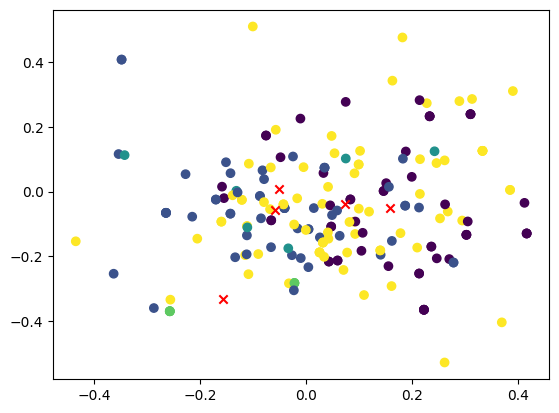

In [263]:
plt.scatter(embeddings_to_plot[:, 0], embeddings_to_plot[:, 1], c=clusters, cmap='viridis')
cluster_centers = kmeans.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x')
plt.show()

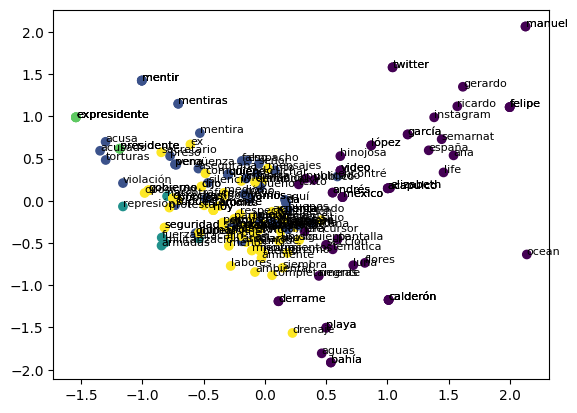

In [264]:
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
for i, (x, y, z) in enumerate(reduced_embeddings):
    plt.annotate(text[i], (x, y), fontsize=8) 
plt.show()

In [265]:
from sklearn.cluster import DBSCAN

In [266]:
dbscan = DBSCAN(eps=3, min_samples=15)

In [267]:
cluster_labels = dbscan.fit_predict(embeddings_to_plot)

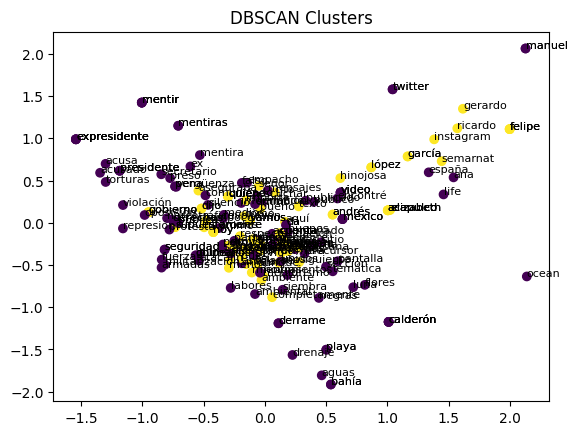

In [268]:
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis')
for i, (x, y, z) in enumerate(reduced_embeddings):
    plt.annotate(text[i], (x, y), fontsize=8)
plt.title("DBSCAN Clusters")
plt.show()

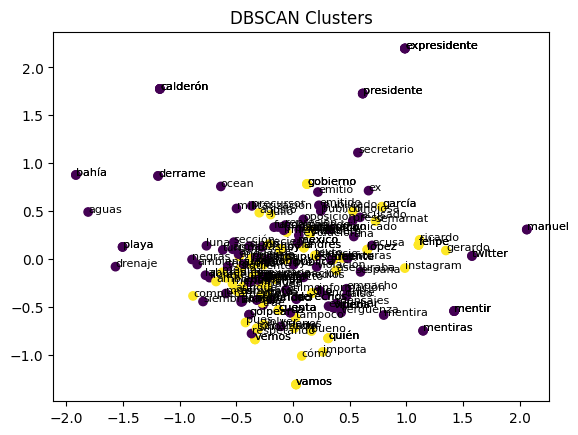

In [269]:
plt.scatter(reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=cluster_labels, cmap='viridis')
for i, (x, y, z) in enumerate(reduced_embeddings):
    plt.annotate(text[i], (y, z), fontsize=8)
plt.title("DBSCAN Clusters")
plt.show()

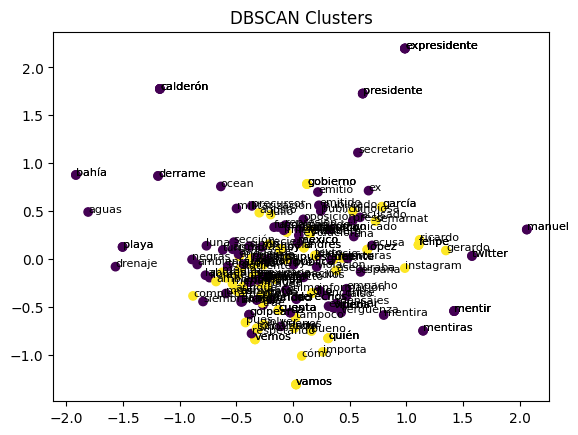

In [271]:
plt.scatter(reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=cluster_labels, cmap='viridis')
for i, (x, y, z) in enumerate(reduced_embeddings):
    plt.annotate(text[i], (y, z), fontsize=8)
plt.title("DBSCAN Clusters")
plt.show()

## Zero Shot
https://huggingface.co/Recognai/bert-base-spanish-wwm-cased-xnli

In [121]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for numba>=0.51.2 from https://files.pythonhosted.org/packages/6e/03/c658004b4b4d52dca7a74582e9fc3e20f94c17cb4b797eb3601876759540/numba-0.58.1-cp38-cp38-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for tbb>=2019.0 from https://files.pythonhosted.org/packages/79/a8/01ac205ff1f68f543aa73d69d6947218cd0973992a4b60cf0a4bfe507561/tbb-2021.10.0-py2.py3-none-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for llvmlite<0.42,>=0.41.0dev0 from https://files.pythonhosted.org/packages/46/a5/de824aba87a62e0da43f9b590ac91709d460a61e03f1b430b83ca64b76dc/llvmlite-0.41.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [95]:
from transformers import pipeline

In [96]:
classifier = pipeline("zero-shot-classification", 
                       model="Recognai/bert-base-spanish-wwm-cased-xnli")

In [97]:
classifier(
    "Maradona ganó el partido",
    candidate_labels=["cultura", "sociedad", "economia", "salud", "seguridad", "educación", "infraestructura"],
    hypothesis_template="Este ejemplo es {}."
)

{'sequence': 'Maradona ganó el partido',
 'labels': ['cultura',
  'seguridad',
  'infraestructura',
  'salud',
  'economia',
  'sociedad',
  'educación'],
 'scores': [0.25365114212036133,
  0.20735694468021393,
  0.17590732872486115,
  0.11877739429473877,
  0.09899412840604782,
  0.07355872541666031,
  0.0717543289065361]}

In [110]:
directory_path  = "output_mañaneras/"
new_corpus      = PlaintextCorpusReader(directory_path, '.*\.txt')

In [111]:
from tqdm import tqdm
import multiprocessing

In [112]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import multiprocessing
results = []

# 10 files, almos 30 minutes

def process_file(file_id):
    text = new_corpus.raw(file_id)
    paragraphs = text.split('\n')
    paragraph_results = []

    for paragraph in paragraphs:
        if not paragraph == "":
            result = classifier(
                paragraph,
                candidate_labels=["cultura", "sociedad", "economia", "salud", "seguridad", "educación", "infraestructura"],
                hypothesis_template="Este ejemplo es {}."
            )
            paragraph_results.append(result["labels"][0])

    return paragraph_results
num_processes = multiprocessing.cpu_count()
file_ids = new_corpus.fileids()[:10]

with tqdm(total=len(file_ids), desc="Processing Files") as pbar:
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        for paragraph_results in executor.map(process_file, file_ids):
            results.extend(paragraph_results)
            pbar.update(1)

Processing Files: 100%|██████████| 10/10 [29:52<00:00, 179.28s/it] 


In [156]:
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('spanish'))
filtered_text = []

for fileid in new_corpus.fileids()[:10]:
    words = word_tokenize(corpus.raw(fileid))
    words = [word for word in words if word.lower() not in stop_words]
    filtered_text.extend(words)
set_filtered_text = list(set(filtered_text))
set_filtered_text = [string.lower() for string in set_filtered_text]

In [157]:
embeddings_zero_shot = np.array([wv_from_bin[word] for word in set_filtered_text if word in wv_from_bin])

In [158]:
text_embs = np.array([word for word in set_filtered_text if word in wv_from_bin])

In [159]:
# Perform t-SNE on the word embeddings
tsne_zs = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d_zs = tsne.fit_transform(embeddings_zero_shot)

In [160]:
i2w_zs = {i: w for i, w in enumerate(text_embs)}

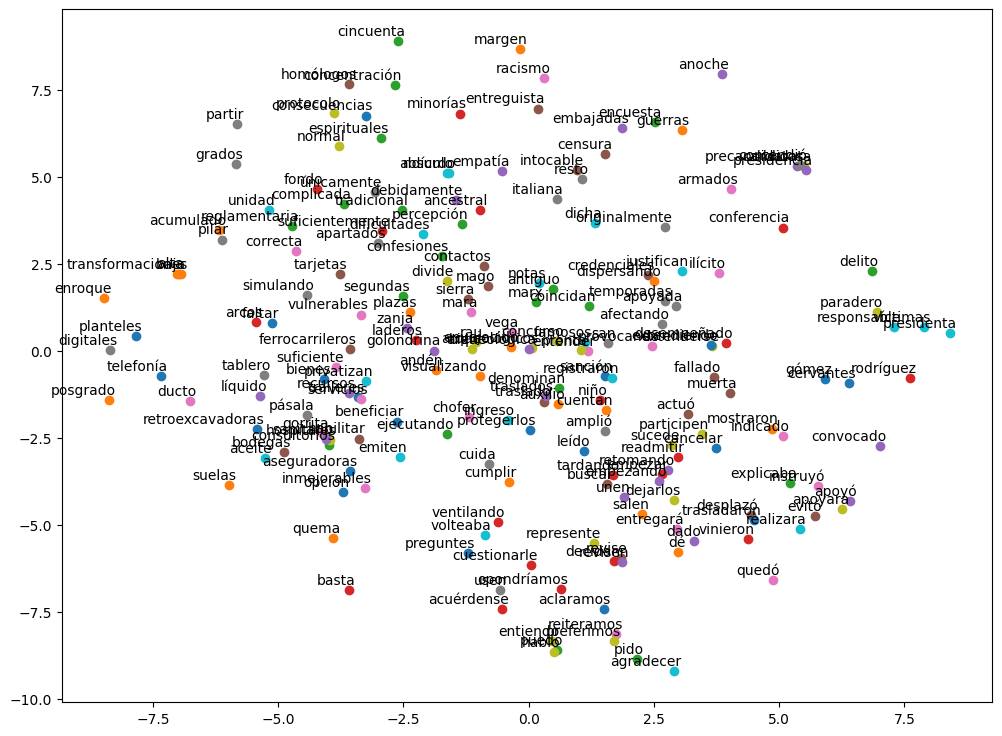

In [161]:
# Visualize the embeddings
plt.figure(figsize=(12, 9))
counter = 0
for i, label in i2w_zs.items():
    if counter == 200:
      break
    if label == "salistes":
        continue
    x, y = embeddings_2d_zs[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    counter += 1

plt.show()

In [162]:
from umap import UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(embeddings_2d_zs)


/opt/conda/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


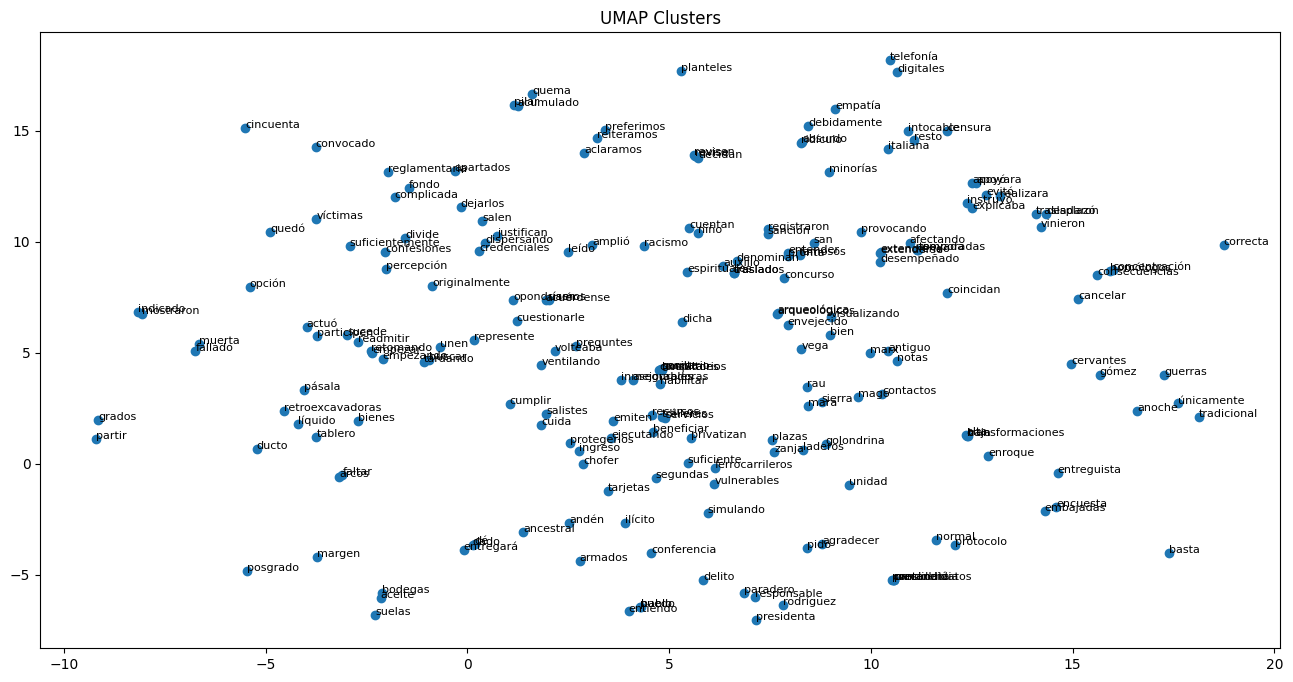

In [163]:
plt.figure(figsize=(16,8))
plt.scatter(proj_2d[:, 0][:200], proj_2d[:, 1][:200])
counter = 0
for i, (x, y) in enumerate(proj_2d):
    if counter == 200:
        break
    plt.annotate(text_embs[i], (x, y), fontsize=8)
    counter += 1
plt.title("UMAP Clusters")
plt.show()

In [164]:
from collections import Counter

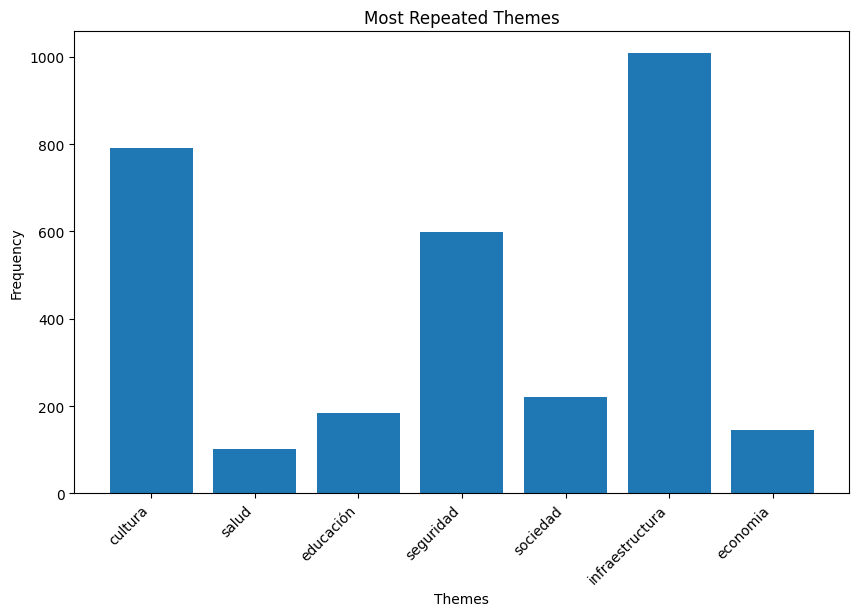

In [165]:
theme_counts = Counter(results)
themes, counts = zip(*theme_counts.items())

plt.figure(figsize=(10, 6))
plt.bar(themes, counts)
plt.xlabel('Themes')
plt.ylabel('Frequency')
plt.title('Most Repeated Themes')
plt.xticks(rotation=45, ha='right')
plt.show()